In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
base = automap_base()

# reflect the tables
base.prepare(engine, reflect = True)

In [7]:
# We can view all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table

Measurement = base.classes.measurement

Station = base.classes.station

In [9]:
# Create our session (link) from Python to the DB

session = Session(engine)

# Exploratory Climate Analysis

In [10]:
inspector = inspect(engine)

columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

engine.execute("select * from Measurement").fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0),
 (11, 'USC00519397', '2010-01-12', 0.0, 61.0),
 (12, 'USC00519397', '2010-01-14', 0.0, 66.0),
 (13, 'USC00519397', '2010-01-15', 0.0, 65.0),
 (14, 'USC00519397', '2010-01-16', 0.0, 68.0),
 (15, 'USC00519397', '2010-01-17', 0.0, 64.0),
 (16, 'USC00519397', '2010-01-18', 0.0, 72.0),
 (17, 'USC00519397', '2010-01-19', 0.0, 66.0),
 (18, 'USC00519397', '2010-01-20', 0.0, 66.0),
 (19, 'USC00519397', '2010-01-21', 0.0, 69.0),
 (20, 'USC00519397', '2010-01-22', 0.0, 67.0),
 (21, 'USC00519397', '2010-01-23', 0.0, 67.0),
 (22, 'USC00519397

In [13]:
# Calculate the date 1 year ago from the last data point in the database

last_date = session.query(func.max(Measurement.date)).all()

last_date

[('2017-08-23')]

In [14]:
# Perform a query to retrieve the data and precipitation scores

last_year_rain = (session.query(Measurement.date, Measurement.prcp)
                  .filter(Measurement.date >= "2016-08-23")
                  .order_by(Measurement.date).all())

# Save the query results as a Pandas DataFrame and set the index to the date column

last_year_rain_df = pd.DataFrame(last_year_rain, columns=['date', 'prcp'])
last_year_rain_df.dropna(subset = ["prcp"], inplace=True)
last_year_rain_df.set_index('date', inplace = True)

# Sort the dataframe by date

last_year_rain_df.sort_values(by='date')

last_year_rain_df

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.00


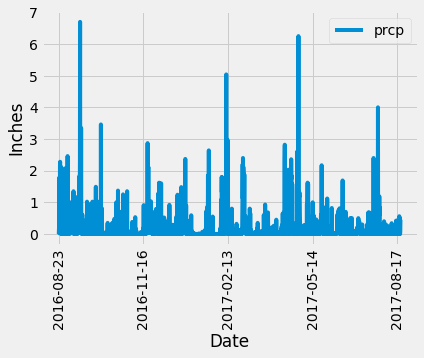

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data

last_year_rain_df.plot(rot=90)

plt.xlabel('Date')
plt.ylabel('Inches')

plt.show()


In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data

last_year_rain_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [17]:
# Design a query to show how many stations are available in this dataset?

station_count = session.query(func.count(Station.station)).all()

station_count[0]

(9)

In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

active_stations = (session.query(Measurement.station, func.count(Measurement.station))
                   .group_by(Measurement.station)
                   .order_by(func.count(Measurement.station).desc())
                   .all())

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
most_active = (session.query(Measurement.station, func.count(Measurement.station))
                   .group_by(Measurement.station)
                   .order_by(func.count(Measurement.station).desc())
                   .first())

most_active[0]

'USC00519281'

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

most_active_station = active_stations[0][0]

print(f"The Most Active Station is: {most_active_station}")

lowest_temp = (session.query(func.min(Measurement.tobs))
               .filter(Measurement.station == most_active_station).all())

print(f"The Lowest Temperature at the Most Active Station is: {lowest_temp[0]} degrees faranheit")

max_temp = (session.query(func.max(Measurement.tobs))
               .filter(Measurement.station == most_active_station).all())

print(f"The Max Temperature at the Most Active Station is: {max_temp[0]} degrees faranheit")

avg_temp = (session.query(func.avg(Measurement.tobs))
               .filter(Measurement.station == most_active_station).all())

print(f"The Average Temperature at the Most Active Station is: {avg_temp[0]} degrees faranheit")


The Most Active Station is: USC00519281
The Lowest Temperature at the Most Active Station is: (54.0,) degrees faranheit
The Max Temperature at the Most Active Station is: (85.0,) degrees faranheit
The Average Temperature at the Most Active Station is: (71.66378066378067,) degrees faranheit


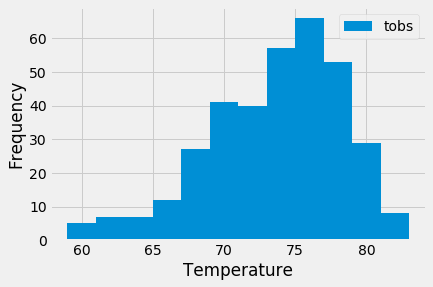

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_observations = (session.query(Measurement.tobs)
                    .filter(Measurement.date >= "2016-08-23")
                    .filter(Measurement.station == "USC00519281")
                    .all())

temp_observations_df = pd.DataFrame(temp_observations)

ax = temp_observations_df.plot(kind='hist', bins=12)

ax.set_xlabel("Temperature")

plt.show()

## Bonus Challenge Assignment

In [22]:
from numpy import mean
from scipy import stats

In [23]:
#find the average temperature in June from all years...and also in December

june_temps_avg = (session.query((Measurement.tobs))
                 .filter(Measurement.date.like('%-06-%'))
                 .all())

dec_temps_avg = (session.query((Measurement.tobs))
                .filter(Measurement.date.like('%-12-%'))
                .all())

print(stats.ttest_ind(june_temps_avg,dec_temps_avg))

print(f"The Average June Temp is: {mean(june_temps_avg)}")

print(f"The Average December Temp is: {mean(dec_temps_avg)}")

# I used an unpaired t-test because the length of each list was different from each other.


Ttest_indResult(statistic=array([31.60372399]), pvalue=array([3.9025129e-191]))
The Average June Temp is: 74.94411764705882
The Average December Temp is: 71.04152933421226


In [24]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [25]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

x_axis = ' '
previous_year_start = '2011-02-28'
previous_year_end = '2011-03-05'

trip_temps = calc_temps(previous_year_start, previous_year_end)

trip_temps


[(61.0, 69.75510204081633, 75.0)]

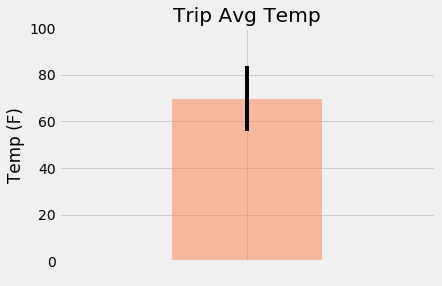

In [26]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

min_temp = trip_temps[0][0]
avg_temp = trip_temps[0][1]
max_temp = trip_temps[0][2]

plt.bar(x_axis,avg_temp, yerr = (max_temp-min_temp), color='coral', alpha = .5)
plt.ylim(0,100)
plt.xlim(-1,1)
plt.ylabel("Temp (F)")
plt.title("Trip Avg Temp")
plt.show()


In [27]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

station_rainfall = (session.query(Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation,func.sum(Measurement.prcp))
                   .filter(Station.station == Measurement.station)
                   .filter(Measurement.date >= previous_year_start)
                   .filter(Measurement.date <= previous_year_end)
                   .group_by(Station.station)
                   .order_by(func.sum(Measurement.prcp).desc())
                   .all())

station_rainfall_df = pd.DataFrame(station_rainfall, columns = ['Station','Station Name','Latitude','Longitude','Elevation','Total Rainfall'])

station_rainfall_df


,Station,Station Name,Latitude,Longitude,Elevation,Total Rainfall
0,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6,2.33
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,2.23
2,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,2.19
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,1.96
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,1.45
5,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,1.44
6,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,1.38
7,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9,0.63
8,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,NaN


In [28]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [29]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

trip_start = '2021-02-28'
trip_end = '2021-03-05'

trip_start = dt.datetime.strptime(trip_start, '%Y-%m-%d')
trip_end = dt.datetime.strptime(trip_end, '%Y-%m-%d')

# Use the start and end date to create a range of dates

date_range = pd.date_range(start = trip_start, end = trip_end)

# Stip off the year and save a list of %m-%d strings

date_range_updated = date_range.strftime("%m-%d")

# Loop through the list of %m-%d strings and calculate the normals for each date

results = []

for date in date_range_updated:
    results.append(*daily_normals(date))
    
results

[(65.0, 70.65517241379311, 80.0),
 (64.0, 70.0327868852459, 76.0),
 (61.0, 70.36666666666666, 78.0),
 (60.0, 70.06896551724138, 78.0),
 (57.0, 69.27272727272727, 77.0),
 (60.0, 67.89090909090909, 76.0)]

In [30]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

trip_normals_df = pd.DataFrame(results, columns = ['tmin', 'tavg', 'tmax'])

trip_normals_df['Date'] = date_range

trip_normals_df.set_index(['Date'], inplace=True)

trip_normals_df


,tmin,tavg,tmax
Date,,,
2021-02-28,65.0,70.655172,80.0
2021-03-01,64.0,70.032787,76.0
2021-03-02,61.0,70.366667,78.0
2021-03-03,60.0,70.068966,78.0
2021-03-04,57.0,69.272727,77.0
2021-03-05,60.0,67.890909,76.0


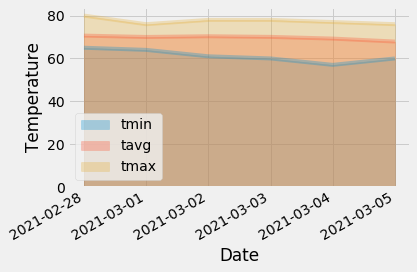

In [31]:
# Plot the daily normals as an area plot with `stacked=False`

trip_normals_df.plot(kind = 'area', stacked=False, alpha=.3, x_compat=True, legend='best')

plt.tight_layout()

plt.xlabel('Date')
plt.ylabel('Temperature')

plt.show()
